In [1]:
### Definining name of analysis ###
# name = '2023-05-26_LinusSteadyLevel'
# data_path = '../../data/'
# result_path = '../Results/'+name+'/'
# figure_path = '../Figures/'+name+'/'

### Definining name of analysis ###
name = '2023-05-26_LinusSteadyLevel_100Hz_Cleaned'
data_path = '../../data/'
data_folder = 'linus-2023-05-26'
file_name_ls = '00000003.BIN'
file_name_hs = '00000004.BIN'

datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
# Getting packages
from os import sys
import os
sys.path.append('../../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.io

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

plt.style.use('../../basic_plotter.mplstyle')

from scipy import optimize

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
# Importing data
df_ls = main.data_load(data_path, data_folder, file_name_ls, "10ms", "linear", "Alton")
df_hs = main.data_load(data_path, data_folder, file_name_hs, "10ms", "linear", "Alton")

In [5]:
# Importing Drag Build Results
build = pd.read_pickle("../../DragBuilds/Linus_DragBuildTurbulent.pkl")

In [6]:
# Defining vehicle
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 1.563 + 0.230
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)

P_systems = 0.3 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

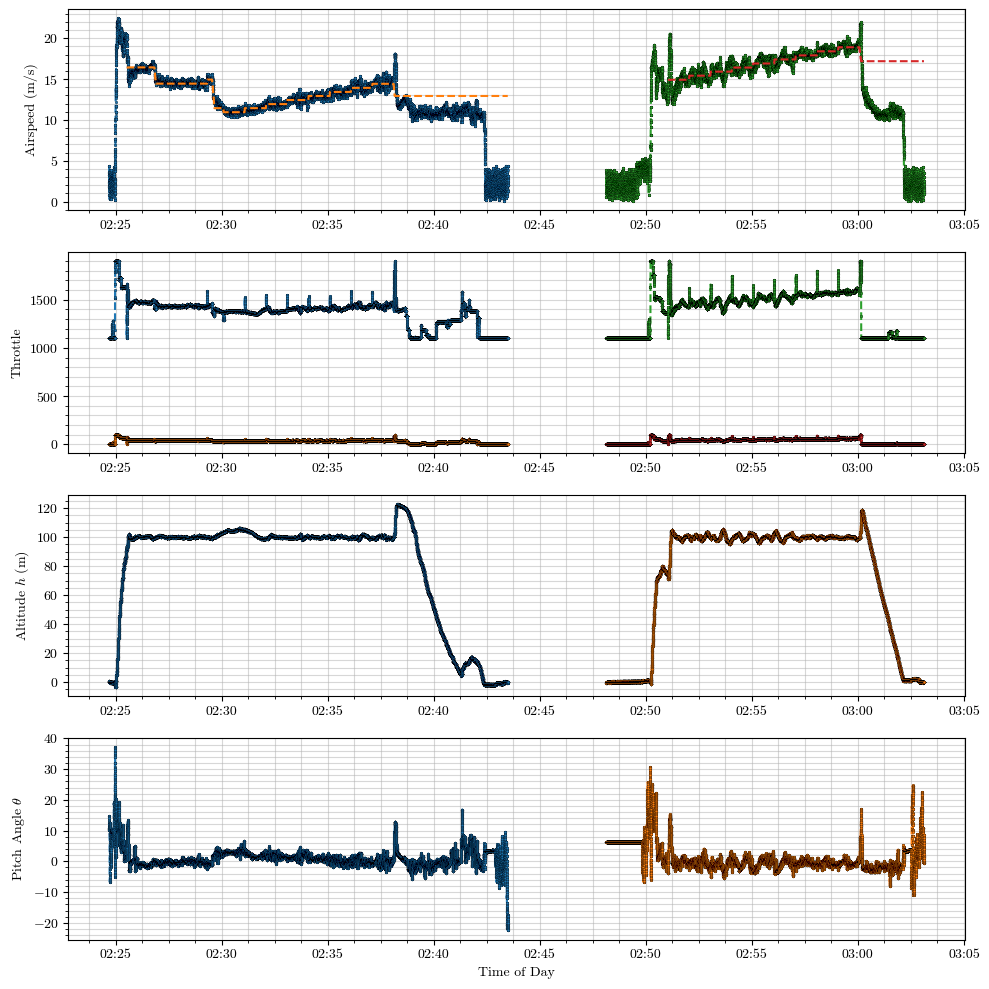

In [7]:
# Creating plots to segment data

plt.figure(figsize=(10,10))
ax0 = plt.subplot(4,1,1)
# plt.grid(which='major', linestyle='-')
# plt.grid(which='minor', linestyle=':', color='grey')
plt.plot(df_ls.index, df_ls.Airspeed_Sensor0, linestyle='--',label="Airspeed sensor (EAS)")
plt.plot(df_ls.index, df_ls.Airspeed_Demanded, linestyle='--',marker='', label="Demanded Airspeed (EAS)")
plt.plot(df_hs.index, df_hs.Airspeed_Sensor0, linestyle='--')
plt.plot(df_hs.index, df_hs.Airspeed_Demanded, linestyle='--',marker='')

plt.ylabel("Airspeed (m/s)")
ax1 = plt.subplot(4,1,2, sharex=ax0)
plt.plot(df_ls.index, df_ls.ThrottleOut, linestyle='--', label='Throttle PWM Output')
plt.plot(df_ls.index, df_ls.Throttle, linestyle='--', label='Throttle Percent')
plt.plot(df_hs.index, df_hs.ThrottleOut, linestyle='--')
plt.plot(df_hs.index, df_hs.Throttle, linestyle='--')
plt.ylabel("Throttle")
ax2 = plt.subplot(4,1,3, sharex=ax0)
plt.plot(df_ls.index, df_ls.Altitude_BARO_0, linestyle='--')
plt.plot(df_hs.index, df_hs.Altitude_BARO_0, linestyle='--')
plt.ylabel("Altitude $h$ (m)")
ax3 = plt.subplot(4,1,4, sharex=ax0)
plt.plot(df_ls.index, df_ls.PitchAngle, linestyle='--')
plt.plot(df_hs.index, df_hs.PitchAngle, linestyle='--')
plt.ylabel("Pitch Angle $\\theta$ ")
plt.xlabel('Time of Day')
plt.show()

In [56]:
# Main Analysis (Low Speed)

# Attitude 
phi = np.deg2rad(df_ls["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df_ls["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df_ls["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df_ls["Pressure_BARO0"].to_numpy() * (287 * (df_ls["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas_ls = df_ls["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas_ls * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df_ls["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df_ls["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df_ls["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df_ls["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df_ls["MainBatteryCurrent"].to_numpy()
v_esc = df_ls["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_ct_ls = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_ct_ls = P_ct_ls + Vd_tas * linus.weight
# Getting drag coefficient
Cd_ct_ls = cl_finders.preq2cd(linus, v_tas, q, P_ct_ls)

# Getting lift coefficient
CL_ls = cl_finders.cl_banked(linus, q, phi)

In [57]:
# Main Analysis (High Speed)

# Attitude 
phi = np.deg2rad(df_hs["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df_hs["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df_hs["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df_hs["Pressure_BARO0"].to_numpy() * (287 * (df_hs["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas_hs = df_hs["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas_hs * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df_hs["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df_hs["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df_hs["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df_hs["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df_hs["MainBatteryCurrent"].to_numpy()
v_esc = df_hs["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_ct_hs = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_ct_hs = P_ct_hs + Vd_tas * linus.weight
# Getting drag coefficient
Cd_ct_hs = cl_finders.preq2cd(linus, v_tas, q, P_ct_hs)
# Getting lift coefficient
CL_hs = cl_finders.cl_banked(linus, q, phi)

In [58]:
### Mask Initialization ###
# Cruise Masking
ls_segtimes = np.array([['02:29:40','02:30:04'],
                      ['02:30:06','02:31:04'],
                      ['02:31:05','02:32:04'],
                      ['02:32:06','02:33:04'],
                      ['02:33:06','02:34:05'],
                      ['02:34:06','02:35:05'],
                      ['02:35:06','02:36:05'],
                      ['02:36:07','02:37:05'],
                      ['02:37:07','02:38:06']])
hs_segtimes = np.array([['02:51:30','02:52:02'],
                      ['02:52:04','02:53:02'],
                      ['02:53:04','02:54:02'],
                      ['02:54:04','02:55:03'],
                      ['02:55:04','02:56:03'],
                      ['02:56:04','02:57:03'],
                      ['02:57:05','02:58:03'],
                      ['02:58:05','02:59:03'],
                      ['02:59:05','03:00:04']])
year = 2023
month = 5
day = 27

masks_ls = cl_finders.get_maskarray(df_ls, ls_segtimes, year, month, day)
masks_hs = cl_finders.get_maskarray(df_hs, hs_segtimes, year, month, day)

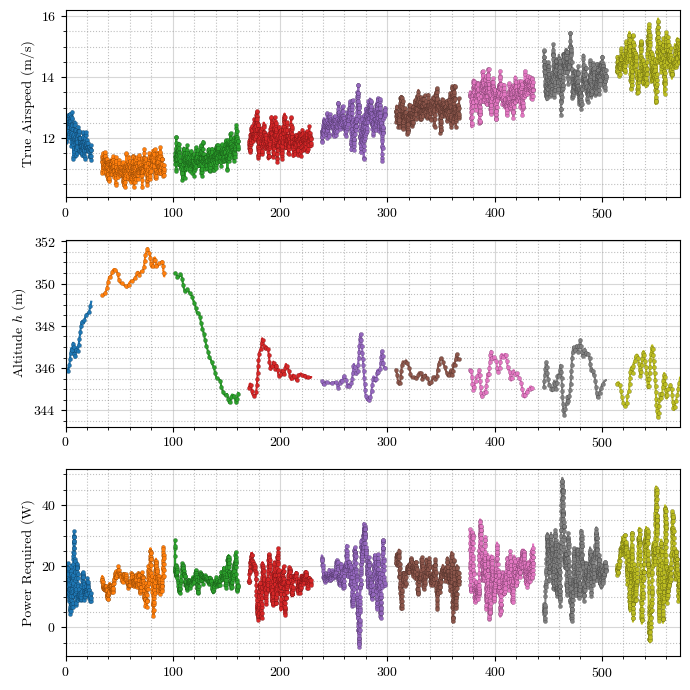

In [59]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 0.01
markedgew = 0.1
plt.figure(figsize=(7,7))
ax1 = plt.subplot(3,1,1)
t_init = 0
for i in range(len(masks_ls)):
    time_s = np.linspace(t_init, (len(df_ls[masks_ls[i]])-1)/100 + t_init, len(df_ls[masks_ls[i]]))
    ax1.plot(time_s, df_ls.Airspeed_Sensor0[masks_ls[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(3,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks_ls)):
    time_s = np.linspace(t_init, (len(df_ls[masks_ls[i]])-1)/100 + t_init, len(df_ls[masks_ls[i]]))
    ax0.plot(time_s, df_ls.Altitude_POS[masks_ls[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(3,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks_ls)):
    time_s = np.linspace(t_init, (len(df_ls[masks_ls[i]])-1)/100 + t_init, len(df_ls[masks_ls[i]]))
    ax2.plot(time_s, P_ct_ls[masks_ls[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

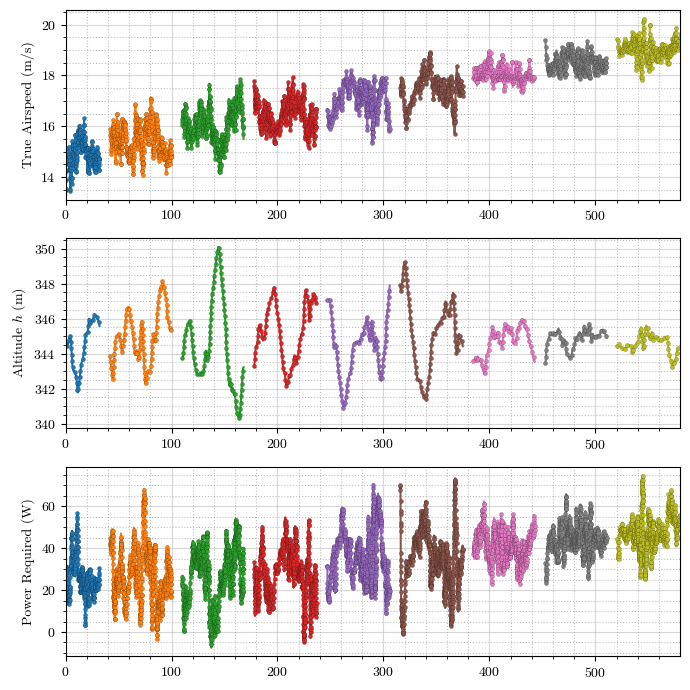

In [60]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 0.01
markedgew = 0.1
plt.figure(figsize=(7,7))
ax1 = plt.subplot(3,1,1)
t_init = 0
for i in range(len(masks_hs)):
    time_s = np.linspace(t_init, (len(df_hs[masks_hs[i]])-1)/100 + t_init, len(df_hs[masks_hs[i]]))
    ax1.plot(time_s, df_hs.Airspeed_Sensor0[masks_hs[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(3,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks_hs)):
    time_s = np.linspace(t_init, (len(df_hs[masks_hs[i]])-1)/100 + t_init, len(df_hs[masks_hs[i]]))
    ax0.plot(time_s, df_hs.Altitude_POS[masks_hs[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(3,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks_hs)):
    time_s = np.linspace(t_init, (len(df_hs[masks_hs[i]])-1)/100 + t_init, len(df_hs[masks_hs[i]]))
    ax2.plot(time_s, P_ct_hs[masks_hs[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

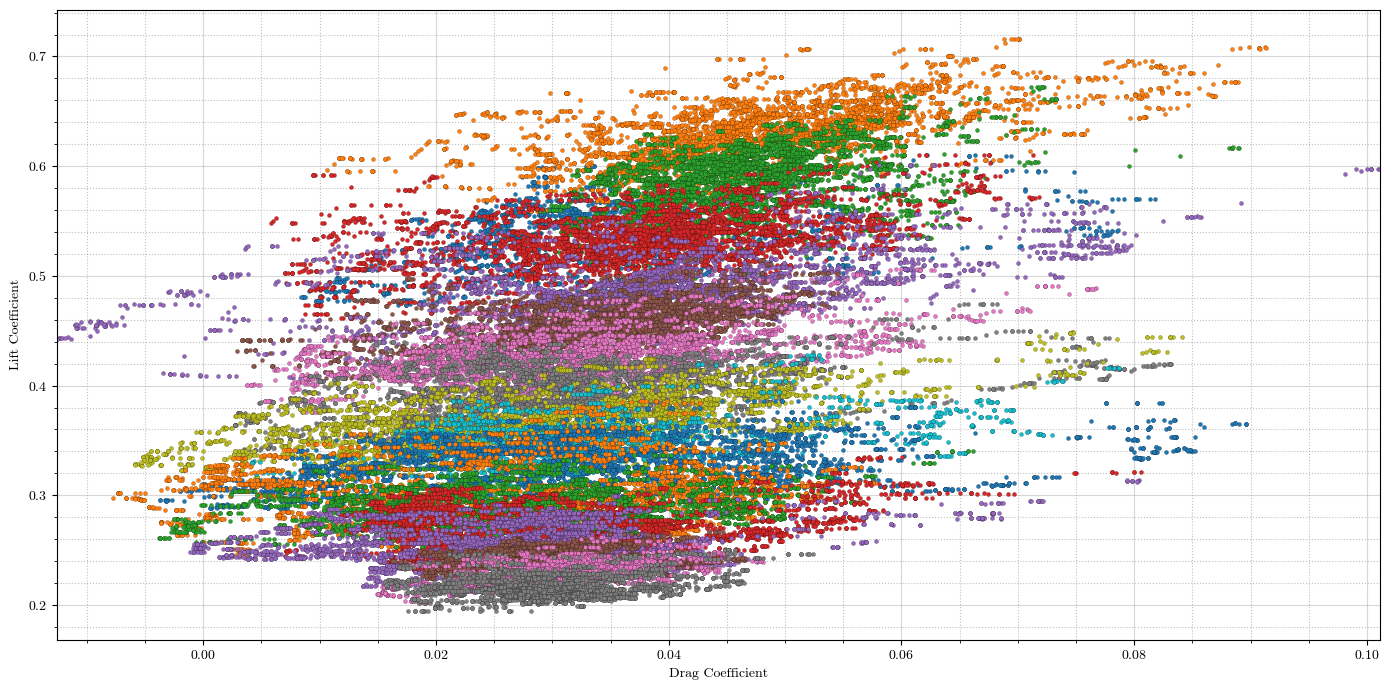

In [61]:
# Plotting the drag polar of the Vehicle

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,1,1)
for i in range(len(masks_ls)):
    ax1.plot(Cd_ct_ls[masks_ls[i]], CL_ls[masks_ls[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
for i in range(len(masks_hs)):
    ax1.plot(Cd_ct_hs[masks_hs[i]], CL_hs[masks_hs[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')

ax1.set_ylabel("Lift Coefficient")
ax1.set_xlabel("Drag Coefficient")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

In [62]:
CL_ls_total = cl_finders.total_segments_boolean(CL_ls, masks_ls)
Cd_ct_ls_total = cl_finders.total_segments_boolean(Cd_ct_ls, masks_ls)

CL_hs_total = cl_finders.total_segments_boolean(CL_hs, masks_hs)
Cd_ct_hs_total = cl_finders.total_segments_boolean(Cd_ct_hs, masks_hs)

CL_total = np.concatenate((CL_ls_total, CL_hs_total))
Cd_ct_total = np.concatenate((Cd_ct_ls_total, Cd_ct_hs_total))

[cl_means_ls, cl_stds_ls, cl_ci95s_ls, cd_means_ls, cd_stds_ls, cd_ci95s_ls] = cl_finders.collect_segments(masks_ls, CL_ls, Cd_ct_ls)
[cl_means_hs, cl_stds_hs, cl_ci95s_hs, cd_means_hs, cd_stds_hs, cd_ci95s_hs] = cl_finders.collect_segments(masks_hs, CL_hs, Cd_ct_hs)

cl_means = np.concatenate((cl_means_ls, cl_means_hs))
cl_stds = np.concatenate((cl_stds_ls, cl_stds_hs))
cl_ci95s = np.concatenate((cl_ci95s_ls, cl_ci95s_hs))

cd_means = np.concatenate((cd_means_ls, cd_means_hs))
cd_stds = np.concatenate((cd_stds_ls, cd_stds_hs))
cd_ci95s = np.concatenate((cd_ci95s_ls, cd_ci95s_hs))

bins=np.linspace(0.2, 0.7, 20)
[cl_means_bin, cl_stds_bin, cl_ci95s_bin, cd_means_bin, cd_stds_bin, cd_ci95s_bin] = cl_finders.collect_bins(bins, CL_total, Cd_ct_total)


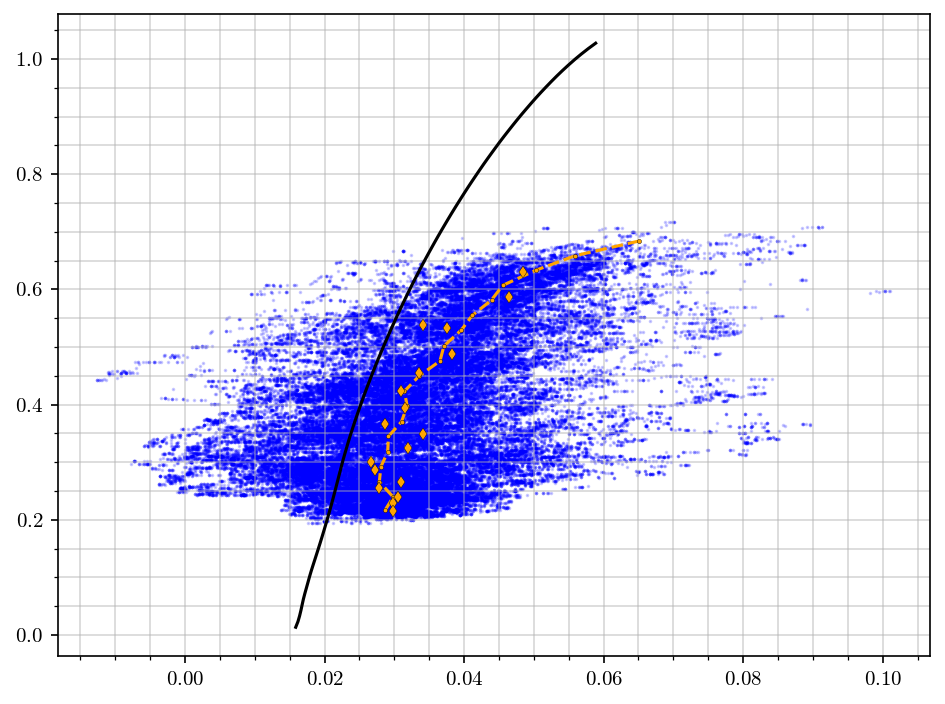

In [65]:
plt.figure(dpi=150)
plt.scatter(Cd_ct_ls_total, CL_ls_total, marker='.', alpha=0.2, s=2, c='blue')
plt.scatter(Cd_ct_hs_total, CL_hs_total, marker='.', alpha=0.2, s=2, c='blue')

plt.plot(build.CD[:106], build.CL[:106], linestyle="solid", color="black", marker="")

plt.plot(cd_means_bin, cl_means_bin, linestyle='--', color='orange')

plt.plot(cd_means_ls, cl_means_ls, linestyle='', marker='d', color='orange')
plt.plot(cd_means_hs, cl_means_hs, linestyle='', marker='d', color='orange')
plt.show()

In [64]:
# Loitering mask (LS)

CL_ave, CD_ave, EAS_ave, CL_95, CD_95, EAS_95 = process_segments(CL_ls, Cd_ct_ls,v_eas_ls, masks_ls)
CL_ave_1, CD_ave_1, EAS_ave_1, CL_95_1, CD_95_1, EAS_95_1 = process_segments(CL_hs, Cd_ct_hs, v_eas_hs, masks_hs)

CL_ave = np.concatenate((CL_ave, CL_ave_1))
CD_ave = np.concatenate((CD_ave, CD_ave_1))
EAS_ave = np.concatenate((EAS_ave, EAS_ave_1))
CL_95 = np.concatenate((CL_95, CL_95_1))
CD_95 = np.concatenate((CD_95, CD_95_1))
EAS_95 = np.concatenate((EAS_95, EAS_95_1))

# Finding drag polar:
polar_ct = cl_finders.cd2polar(linus, CD_ave, CL_ave, highorder=False)
#polar_ct = [0.025, 1]
# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_ct, EAS = cl_finders.polar2preqew(linus, polar_ct, (8,28), createvstandardweight=False)
CL_fitted, CD_fitted = cl_finders.plotfittedpolar(linus, polar_ct, np.array([0.06, 0.9]))

plt.figure()
plt.plot(CD_ave, CL_ave, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
plt.plot(CD_fitted, CL_fitted, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='-')
plt.show()

print(polar_ct)
print(polar_ct[1])
K = polar_ct[1]
e = (np.pi * linus.AR * K)**-1
print(e)



NameError: name 'process_segments' is not defined

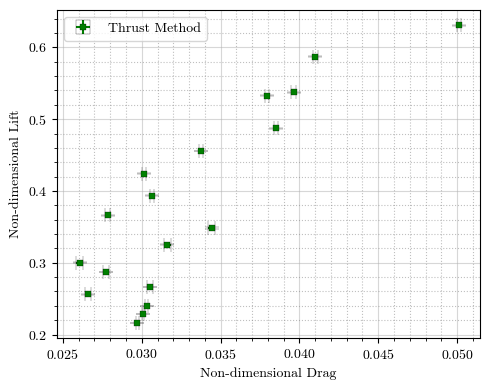

In [ ]:
# Drag Polar plots #

# 95% Confidence Interval!
plt.figure(figsize=(5,4))
plt.errorbar(CD_ave, CL_ave, xerr=CD_95, yerr=CL_95, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()

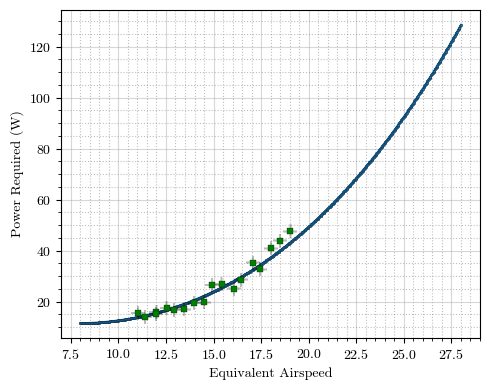

In [ ]:
# Drag Polar plots #

plt.figure(figsize=(5,4))
plt.plot(EAS, Peq_ct, label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(EAS_ave, CD_ave * 0.5 * 1.225 * EAS_ave**3 * linus.area, xerr=EAS_95, yerr=CD_95* 0.5 * 1.225 * EAS_ave**3 * linus.area, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])

plt.xlabel("Equivalent Airspeed")
plt.ylabel("Power Required (W)")
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()

In [ ]:
# Fitting the results
polar_steady = cl_finders.cd2polar(linus, cd_means, cl_means, highorder=False)

# Packaging the results
cruise_binresult = cl_finders.packaging_binresults(CL_total, cl_means, cl_stds, cl_ci95s, Cd_ct_total, cd_means, cd_stds, cd_ci95s, polar_steady, linus)

In [ ]:
# Exporting workspace
import dill
location = result_path + 'workspace.pkl'
dill.dump_session(location)

# Exporting polar data
pd.to_pickle(cruise_binresult, result_path+'ct_binresult.pkl')